In [1]:
# Importing libraries 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import PIL 
import tensorflow as tf 
import json
import pathlib

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 

from tfmesos2 import cluster


2023-11-07 18:00:02.971656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 18:00:03.002856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 18:00:03.002885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 18:00:03.002904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 18:00:03.008153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 18:00:03.008502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
os.environ["MESOS_MASTER"] = "devtest.lab.local:5050"
os.environ["MESOS_SSL"] = "true"
os.environ["MESOS_USERNAME"] = "mesos"
os.environ["MESOS_PASSWORD"] = "test"

client_ip = "192.168.150.6"

extra_kw = {}
extra_kw['fetcher'] = {"http://192.168.150.6:11000/v0/download/flower_photos.tgz":"true"}

data_dir = pathlib.Path("/mnt/mesos/sandbox/flower_photos/")

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory( 
	data_dir, 
	validation_split=0.2, 
	subset="training", 
	seed=123, 
	image_size=(180, 180), 
	batch_size=32,
    shuffle=True) 


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [4]:

val_ds = tf.keras.utils.image_dataset_from_directory( 
    data_dir, 
    validation_split=0.2, 
    subset="validation", 
    seed=123, 
    image_size=(180,180), 
    batch_size=32,
    shuffle=True
    ) 

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [5]:
class_names = train_ds.class_names 
print(class_names)

num_classes = len(class_names) 

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


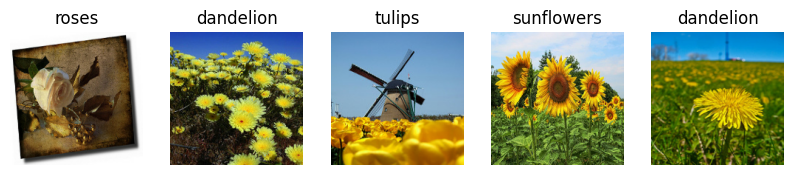

In [6]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10)) 

for images, labels in train_ds.take(1): 
	for i in range(5): 
		ax = plt.subplot(5, 5, i + 1) 
		plt.imshow(images[i].numpy().astype("uint8")) 
		plt.title(class_names[labels[i]]) 
		plt.axis("off") 


In [7]:
jobs_def = [
    {
        "name": "ps",
        "num": 1,
        "mem": 200
    },
    {
        "name": "worker",
        "num": 2
    },
]

with cluster(jobs_def, client_ip=client_ip, **extra_kw) as c:
    os.environ["TF_CONFIG"] = json.dumps({
        "cluster": c.cluster_def
    })

    print(os.environ["TF_CONFIG"])

    cluster_resolver = tf.distribute.cluster_resolver.TFConfigClusterResolver()

    strategy = tf.distribute.ParameterServerStrategy(cluster_resolver)    

    with strategy.scope():
        model = Sequential([ 
        	layers.Rescaling(1./255, input_shape=(180,180, 3)), 
        	layers.Conv2D(16, 3, padding='same', activation='relu'), 
        	layers.MaxPooling2D(), 
        	layers.Conv2D(32, 3, padding='same', activation='relu'), 
        	layers.MaxPooling2D(), 
        	layers.Conv2D(64, 3, padding='same', activation='relu'), 
        	layers.MaxPooling2D(), 
        	layers.Flatten(), 
        	layers.Dense(128, activation='relu'), 
        	layers.Dense(num_classes) 
        ]) 


        optimizer = tf.keras.optimizers.Adam()

        model.compile(optimizer=optimizer, 
    		  		  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    				  metrics=['accuracy']) 
        
    model.summary()     

    epochs=10

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)           

2023-11-07 18:00:04,922 INFO: MesosFramework master : devtest.lab.local:5050, name : tf, id : None
2023-11-07 18:00:04,926 INFO: try to register
2023-11-07 18:00:04,926 INFO: Cluster not ready
2023-11-07 18:00:04,927 WARNING: Try to connect to master: https://devtest.lab.local:5050
2023-11-07 18:00:04,928 INFO: Serving on http://0.0.0.0:11000
2023-11-07 18:00:04,982 INFO: Mesos:Subscribe:Framework-Id:2fa6a9c7-f295-492f-9b86-2f82e3bd5b68-0058
2023-11-07 18:00:04,983 INFO: Mesos:Subscribe:Stream-Id:ac90e111-741e-4dec-868e-940a49188daa
2023-11-07 18:00:14,928 INFO: Cluster not ready
2023-11-07 18:00:19,982 INFO: Launching task 9736e7cf-752c-4efa-a707-69bd6f9adcf8 using offer 2fa6a9c7-f295-492f-9b86-2f82e3bd5b68-O492
2023-11-07 18:00:24,930 INFO: Cluster not ready
2023-11-07 18:00:34,931 INFO: Cluster not ready
2023-11-07 18:00:34,987 INFO: Launching task 42d230f8-6fb5-4475-8e18-1a1335581030 using offer 2fa6a9c7-f295-492f-9b86-2f82e3bd5b68-O493
2023-11-07 18:00:44,822 INFO: Launching task 

{"cluster": {"ps": ["192.168.150.9:53965"], "worker": ["192.168.150.9:59289", "192.168.150.9:36563"]}}
INFO:tensorflow:`tf.distribute.experimental.ParameterServerStrategy` is initialized with cluster_spec: ClusterSpec({'ps': ['192.168.150.9:53965'], 'worker': ['192.168.150.9:59289', '192.168.150.9:36563']})


2023-11-07 18:02:55,058 INFO: `tf.distribute.experimental.ParameterServerStrategy` is initialized with cluster_spec: ClusterSpec({'ps': ['192.168.150.9:53965'], 'worker': ['192.168.150.9:59289', '192.168.150.9:36563']})


INFO:tensorflow:ParameterServerStrategyV2 is now connecting to cluster with cluster_spec: ClusterSpec({'ps': ['192.168.150.9:53965'], 'worker': ['192.168.150.9:59289', '192.168.150.9:36563']})


2023-11-07 18:02:55,059 INFO: ParameterServerStrategyV2 is now connecting to cluster with cluster_spec: ClusterSpec({'ps': ['192.168.150.9:53965'], 'worker': ['192.168.150.9:59289', '192.168.150.9:36563']})
2023-11-07 18:02:55,060 INFO: default session config: device_count {
  key: "GPU"
  value: 0
}
device_count {
  key: "CPU"
  value: 1
}
gpu_options {
  experimental {
  }
}
allow_soft_placement: true
experimental {
  collective_group_leader: "/job:worker/replica:0/task:0"
}



INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:chief/replica:0/task:0/device:CPU:0'], variable_device = '/job:chief/replica:0/task:0/device:CPU:0'


2023-11-07 18:02:55.091273: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:457] Started server with target: grpc://localhost:44247
2023-11-07 18:02:55,091 INFO: ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:chief/replica:0/task:0/device:CPU:0'], variable_device = '/job:chief/replica:0/task:0/device:CPU:0'


INFO:tensorflow:Number of GPUs on workers: 0


2023-11-07 18:02:55,093 INFO: Number of GPUs on workers: 0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/tensorflow/python/data/ops/dataset_ops.py:458: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,364 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,387 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,388 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,389 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,390 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,392 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,393 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,395 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,396 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


2023-11-07 18:02:56,397 INFO: Reduce to /device:CPU:0 then broadcast to ('/replica:0/device:CPU:0',).


ERROR:tensorflow: /job:worker/task:0 encountered the following error when processing closure: OutOfRangeError():Graph execution error:

Detected at node cond/IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3

2023-11-07 18:15:25.261697: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:59] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 28068, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0 while calling /tensorflow.eager.EagerService/Enqueue:
:{"created":"@1699377325.258228188","description":"Error received from peer ipv4:192.168.150.9:59289","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 28068, Output num: 1","grpc_status":3} [type.googleapis.com/tensorflow.core.platform.ErrorSourceProto='\x08\x05']
2023-11-07 18:15:25,263 ERROR:  /job:worker/task:0 encountered the following error when processing closure: OutOfRangeError():Graph execution error:

Detected at node cond/IteratorGetNext defined at (most recent call la

ERROR:tensorflow:Start cancelling closures due to error OutOfRangeError(): Graph execution error:

Detected at node cond/IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _

2023-11-07 18:15:25,281 ERROR: Start cancelling closures due to error OutOfRangeError(): Graph execution error:

Detected at node cond/IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py",

ERROR:tensorflow: /job:worker/task:0 encountered the following error when processing closure: OutOfRangeError():Graph execution error:

Detected at node cond/IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3

2023-11-07 18:15:25,287 ERROR:  /job:worker/task:0 encountered the following error when processing closure: OutOfRangeError():Graph execution error:

Detected at node cond/IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/andreas/.virtualenvs/mesos-cli/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/u

INFO:tensorflow:Canceling all closures: waiting for inflight closures to finish


2023-11-07 18:15:25,289 INFO: Canceling all closures: waiting for inflight closures to finish


ERROR:tensorflow:Remote function on worker /job:worker/replica:0/task:1 failed with CancelledError():Cancelled
Additional GRPC error information from remote target /job:worker/replica:0/task:1 while calling /tensorflow.eager.EagerService/Enqueue:
:{"created":"@1699377325.289525342","description":"Error received from peer ipv4:192.168.150.9:36563","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Cancelled","grpc_status":1} [Op:__inference_train_function_1862]
This derived error is ignored and not reported to users.


2023-11-07 18:15:25,300 ERROR: Remote function on worker /job:worker/replica:0/task:1 failed with CancelledError():Cancelled
Additional GRPC error information from remote target /job:worker/replica:0/task:1 while calling /tensorflow.eager.EagerService/Enqueue:
:{"created":"@1699377325.289525342","description":"Error received from peer ipv4:192.168.150.9:36563","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Cancelled","grpc_status":1} [Op:__inference_train_function_1862]
This derived error is ignored and not reported to users.


INFO:tensorflow:Canceling all closures: canceling remaining closures on the queue


2023-11-07 18:16:04,158 INFO: Canceling all closures: canceling remaining closures on the queue
2023-11-07 18:16:04,159 INFO: Cluster teardown
2023-11-07 18:16:05,298 ERROR: All connection tries failed


CancelledError: RemoteExecuteNode::RunAsync [Op:__inference_train_function_1862]

In [ ]:
#Accuracy 
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 

#loss 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

#epochs 
epochs_range = range(epochs) 

#Plotting graphs 
plt.figure(figsize=(8, 8)) 
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show() 
